<a href="https://colab.research.google.com/github/geoffcorvera/cnn/blob/colab/catdog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Build model on top of CNN pre-trained on ImageNet dataset. The final classification layer contains a single neuron with output in range [0,1].

In [2]:
import os
import numpy as np 
from tensorflow.keras.applications import InceptionResNetV2
from keras import models
from keras import layers

In [1]:
# Confirm TPU connection
import tensorflow as tf 

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [3]:
# Load resnet pretrained on ImageNet
pre_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
pre_model.trainable = False

219062272/219055592 [==============================] - 2s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

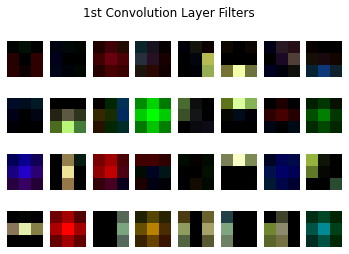

In [4]:
import matplotlib.pyplot as plt

# Visualize inception resnet first layer filters
def getConvLayer(model):
  res = None
  for layer in model.layers:
    if 'conv' in layer.name:
      res = layer
      break
  return res

def visualizeFilters(filters):
  # filters = filters[0]
  nf = filters.shape[3]
  fig, _ = plt.subplots(4,8)
  
  for i, ax in enumerate(fig.axes):
    ax.imshow(filters[:,:,:,i])
    ax.set_axis_off()
  fig.suptitle('1st Convolution Layer Filters')
  plt.show()


conv_layer = getConvLayer(pre_model)
filters = conv_layer.get_weights()
visualizeFilters(conv_layer.get_weights()[0])

In [5]:
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing as preprocessing_layers

print('Building model...\n')

data_augmentation = keras.Sequential(
    [
      preprocessing_layers.RandomFlip('horizontal'),
      preprocessing_layers.RandomRotation(0.1),
      preprocessing_layers.RandomZoom(0.1),
    ]
)

input_shape = (150,150,3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)           #Augment data to increase training set
x = preprocessing_layers.Rescaling(1.0/255)(x) #Rescale image values to [0,1]

outputs = pre_model(x)
outputs = layers.Flatten()(outputs)
outputs = layers.Dense(256, activation='relu')(outputs)
outputs = layers.Dense(1, activation='sigmoid')(outputs)

model = keras.Model(inputs, outputs)

model.summary()

Building model...

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3539200   
_________________________________________________________________
dense_1 (Dense)              (None, 1)    

In [6]:
import tensorflow.keras.preprocessing as preprocessing
from google.colab import drive

print('Importing training and test datasets...\n')
training_dir = r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/p3_data/cats_dogs_dataset.zip (Unzipped Files)/dataset/training_set'
train_ds = preprocessing.image_dataset_from_directory(training_dir, image_size=(150,150))
# train_ds = train_ds.shuffle(buffer_size=1024).batch(64)

test_dir = r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/p3_data/cats_dogs_dataset.zip (Unzipped Files)/dataset/test_set'
test_ds = preprocessing.image_dataset_from_directory(test_dir, image_size=(150,150))


Importing training and test datasets...

Found 8000 files belonging to 2 classes.
Found 2000 files belonging to 4 classes.


In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
checkpoint_path = r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/training'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(optimizer='rmsprop', loss='binary_crossentropy')
print('Fitting to data...\n')
history = model.fit(train_ds, epochs=3, callbacks=[cp_callback])

os.listdir(checkpoint_dir)

Fitting to data...

Epoch 1/3
 74/250 [=======>......................] - ETA: 22:20 - loss: 10.3093

In [11]:
print('Evaluating against test...\n')
results = model.evaluate(test_ds)

Evaluate...

63/63 [==============================] - 10s 141ms/step - loss: 225.6516
225.651611328125
